In [1]:
import numpy as np
from __future__ import division
import itertools
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf

In [86]:
# 1 and 2 Parts)
class TicTacToe:
    
    def __init__(self, tf = tf, start_rand = False, player = np.random.choice([-1,1])):
        self.player_id = player
        self.start_rand = start_rand
        self.board = np.zeros(9,dtype = int)
        self.score = [0,0,0]
        self.rewards = np.zeros(10000)
        self.Q_table = defaultdict(lambda: np.zeros(9))
        self.learning_rate0 = 0.05
        self.learning_rate_decay = 0.1
        self.X = tf.placeholder(shape = [None, 9], dtype = tf.float32)
        self.t = tf.placeholder(dtype = tf.float32)
        self.a = tf.placeholder(dtype = tf.int32)

        self.dense = tf.layers.dense(self.X, units = 10,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01,dtype=tf.float32), activation = tf.nn.relu)
        self.output = tf.layers.dense(self.X, units = 9,kernel_initializer = tf.truncated_normal_initializer(stddev=0.01,dtype=tf.float32) , activation = None)
        self.loss = tf.square(self.t-self.output[0,self.a])
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
        self.train = self.optimizer.minimize(self.loss)


        combin = []
        
        for i in itertools.combinations(range(9), 3):
            combin.append(i) if (np.diff(np.diff(i)) == 0) and (i[0] == 2 if np.diff(i)[0] == 2 else True) and (i[0] in [0,3,6] if np.diff(i)[0] == 1 else True) else "n"
        combin = [list(x) for x in combin]
        self.combin = combin
        
    def random_move(self,player):
        moves_ = self.legal_moves()
        return moves_ if moves_ == -2 else np.random.choice(moves_[0])
    def smart_move(self,player):
        if self.player_id == player and (2 in np.sum(self.board[[self.combin]] == player,1)):
            combos = np.where(np.sum(self.board[[self.combin]] == player,1) == 2)[0][0]
            movess = [i for i in self.combin[combos] if self.board[i] == 0]
            if len(movess) > 0:
                return movess[0]
            else:
                return self.random_move(player)
        else:
            return self.random_move(player)
    def smarter_move(self,player):
        if self.player_id == player and ((2 in np.sum(self.board[[self.combin]] == player,1)) or (2 in np.sum(self.board[[self.combin]] == -1*player,1))):
            if (2 in np.sum(self.board[[self.combin]] == player,1)):
                combos = np.where(np.sum(self.board[[self.combin]] == player,1) == 2)[0][0]
                movess = [i for i in self.combin[combos] if self.board[i] == 0]
                if len(movess) > 0:
                    return movess[0]
                else:
                    return self.random_move(player)
            elif (2 in np.sum(self.board[[self.combin]] == -1*player,1)):
                combos = np.where(np.sum(self.board[[self.combin]] == -1*player,1) == 2)[0][0]
                movess = [i for i in self.combin[combos] if self.board[i] == 0]
                if len(movess) > 0:
                    return movess[0]
                else:
                    return self.random_move(player)
        else:
            return self.random_move(player)
    def dq_move(self,player):
        moves_ = self.legal_moves()
        if moves_ == -2:
            return moves_
        else:
            moves_values = self.sess.run(self.output, {self.X: np.reshape(self.board, (1,9))})
            moves_values = list(moves_values[0])
#             print "moves = ", moves_values
            max_index = -1
            max_value = -100
            for i in moves_[0]:
                if moves_values[i] > max_value:
                    max_index = i
            return max_index
    def q_move(self,player):
        moves_ = self.legal_moves()
        if moves_ == -2:
            return moves_
        else:
#         print "moves = ",self.Q_table[str(self.board)]
#         print "legal = ",self.Q_table[str(self.board)][moves_[0]]
#         print "max value = ", max(self.Q_table[str(self.board)][moves_[0]])
            moves_values = self.Q_table[str(self.board)]
            max_index = -1
            max_value = -100
            for i in moves_[0]:
                if moves_values[i] > max_value:
                    max_index = i
            return max_index
    def updateQ(self,s,a,s_,r,i):
#         learning_rate = self.learning_rate0 / (1 + i * self.learning_rate_decay)
        self.Q_table[s][a] = r +  max(self.Q_table[s_])
        
    def updateDQ(self,s,a,s_,r):
        self.Q_table[s][a] = r + max(self.Q_table[s_])   
#         print "the next line = ",self.Q_matr[s_] 
#         print "Reward = ",r, "Update = ",r + (abs(r) == 1)*max(self.Q_matr[s_])
    def reward(self): 
        return 1 if (3 in np.sum(self.board[[self.combin]] == 1,1)) else (-1 if (3 in np.sum(self.board[[self.combin]] == -1,1)) else 0)
    def move(self, i):
        if i == -2:
            return -2
        else:
            self.board[i] = self.player_id
            
            self.player_id = -1*self.player_id
            return self.reward()
        
    def tf_play(self,move_type_1=1, move_type_2 = 1, player_1 = -1, player_2 = 1, histogram = True, dq_learning_1 = False):
        moves = [self.dq_move,self.random_move,self.smart_move,self.smarter_move]
        move_1 = moves[move_type_1]
        move_2 = moves[move_type_2]
        self.score = [0,0,0]
        sum_ = 0
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.rewards = np.zeros(10000)
        
        for i in range(10000):
            
            if self.start_rand == True:
                self.player_id = np.random.choice([-1,1])
            temp = 0
            self.board = np.zeros(9,dtype = int)
            first = False
            while not temp in [-1,1,-2]:
                    
                if self.player_id == player_1:
                    first = True
                    s = str(self.board)
                    a_ = move_1(player_1)
                    temp = self.move(a_)
                    if dq_learning_1 == True and temp in [-1,-2]:
                        s_ = str(self.board)
#                         self.updateDQ(s,a,s_,2 + temp)
                        for j in range(10):
                            self.sess.run(self.train, {self.X: np.reshape(self.board, (1,9)), self.a: a_, self.t: 2 + temp})
                
                else:
                    
                    s_ = str(self.board)
                    temp = self.move(move_2(player_2))
                    if dq_learning_1 == True and first:
                        if temp == -2:
#                             self.updateDQ(s,a_,s_,0)
                            for j in range(10):
                                self.sess.run(self.train, {self.X: np.reshape(self.board, (1,9)), self.a: a_, self.t: 0})
                        elif temp == 1:
#                             self.updateDQ(s,a_,s_,-1)
                            for j in range(10):
                                self.sess.run(self.train, {self.X: np.reshape(self.board, (1,9)), self.a: a_, self.t: -1})
                
            if temp == -2:
                self.score[2] += 1
                self.rewards[i] = self.rewards[i-1] if i != 0 else 0
            else:
                index = 0 if temp == -1 else 1
                self.score[index] += 1
                sum_ += -1*temp
                self.rewards[i] = sum_
        if histogram:
            res = self.score
            plt.hist(np.concatenate((np.zeros(self.score[0]), np.ones(self.score[1]), np.ones(self.score[2])+1), axis=0))
            plt.show()
            plt.plot(self.rewards)
            plt.title("Cumulative sum of rewards")
            plt.show()
            print "For the 1 Player:\n Number of wins = ",res[0],"\n Number of losses = ", res[1],"\n Number of draws = ", res[2]
        return self.score

    def run_play(self,move_type_1=1, move_type_2 = 1, player_1 = -1, player_2 = 1,histogram = True, q_learning_1 = False):
        moves = [self.q_move,self.random_move,self.smart_move,self.smarter_move]
        move_1 = moves[move_type_1]
        move_2 = moves[move_type_2]
        self.score = [0,0,0]
        self.rewards = np.zeros(10000)
        sum_ = 0
        
        for i in range(10000):
            
            if self.start_rand == True:
                self.player_id = np.random.choice([-1,1])
            temp = 0
            self.board = np.zeros(9,dtype = int)
            first = False
            while not temp in [-1,1,-2]:
                    
                if self.player_id == player_1:
                    first = True
                    s = str(self.board)
                    a = move_1(player_1)
                    temp = self.move(a)
                    if q_learning_1 == True and temp in [-1,-2]:
                        s_ = str(self.board)
                        self.updateQ(s,a,s_,2 + temp,i)
                
                else:
                    
                    s_ = str(self.board)
                    temp = self.move(move_2(player_2))
                    if q_learning_1 == True and first:
                        if temp == -2:
                            self.updateQ(s,a,s_,0,i)
                        elif temp == 1:
                            self.updateQ(s,a,s_,-1,i)
                
            if temp == -2:
                self.score[2] += 1
                self.rewards[i] = self.rewards[i-1] if i != 0 else 0
            else:
                index = 0 if temp == -1 else 1
                self.score[index] += 1
                sum_ += -1*temp
                self.rewards[i] = sum_
        if histogram:
            res = self.score
            plt.hist(np.concatenate((np.zeros(self.score[0]), np.ones(self.score[1]), np.ones(self.score[2])+1), axis=0))
            plt.show()
            plt.plot(self.rewards)
            plt.title("Cumulative sum of rewards")
            plt.show()
            print "For the 1 Player:\n Number of wins = ",res[0],"\n Number of losses = ", res[1],"\n Number of draws = ", res[2]
        return self.score
    def legal_moves(self):
        return np.where(self.board == 0) if np.sum(a.board == 0) > 0 else -2

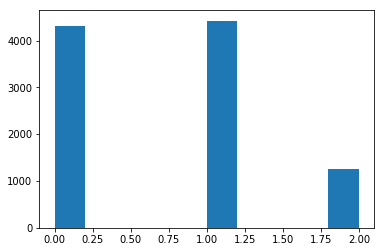

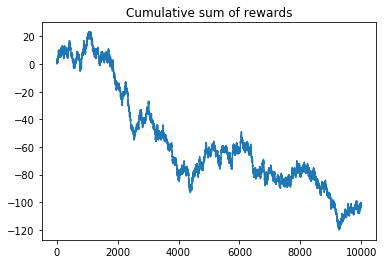

For the 1 Player:
 Number of wins =  4319 
 Number of losses =  4423 
 Number of draws =  1258


[4319, 4423, 1258]

In [13]:
# Players are equaly strong
a = TicTacToe(start_rand = False)
a.run_play()

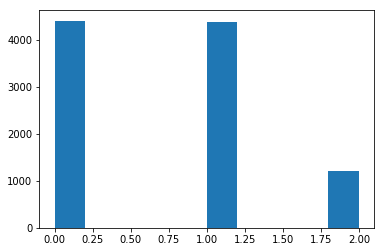

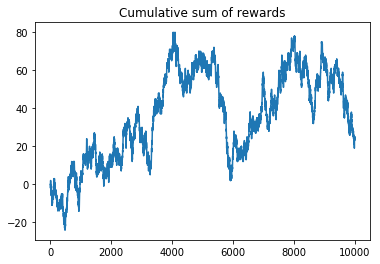

For the 1 Player:
 Number of wins =  4404 
 Number of losses =  4379 
 Number of draws =  1217


[4404, 4379, 1217]

In [14]:
# Each game player is chosen randomly
a = TicTacToe(start_rand = True)
a.run_play()

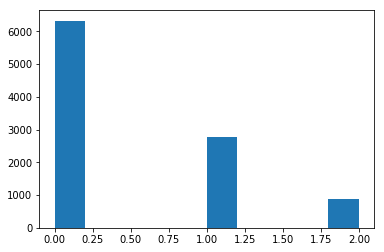

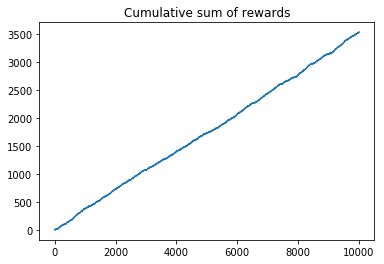

For the 1 Player:
 Number of wins =  6327 
 Number of losses =  2787 
 Number of draws =  886


[6327, 2787, 886]

In [139]:
# Player 1 is 'smart'
a = TicTacToe(start_rand = True)
a.run_play(2)

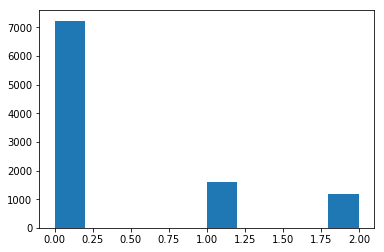

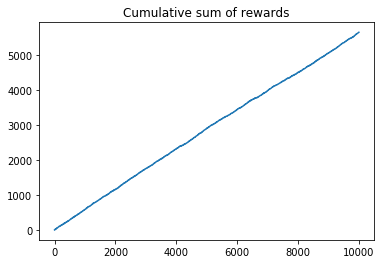

For the 1 Player:
 Number of wins =  7231 
 Number of losses =  1589 
 Number of draws =  1180


[7231, 1589, 1180]

In [140]:
# Player 1 is 'smarter'
a = TicTacToe(start_rand = True)
a.run_play(3)

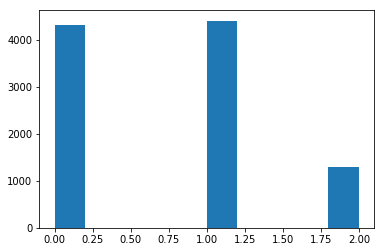

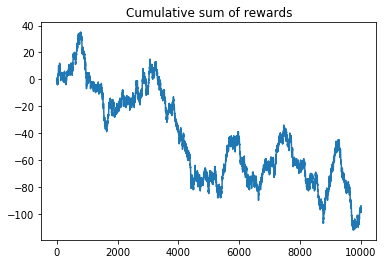

For the 1 Player:
 Number of wins =  4309 
 Number of losses =  4403 
 Number of draws =  1288
Player 1, level =  0
Player 2, level =  0


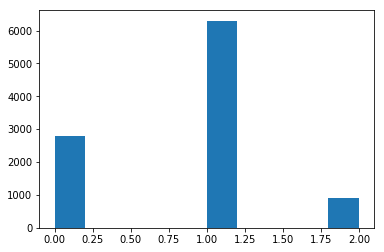

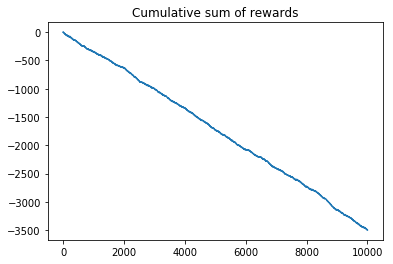

For the 1 Player:
 Number of wins =  2801 
 Number of losses =  6298 
 Number of draws =  901
Player 1, level =  0
Player 2, level =  1


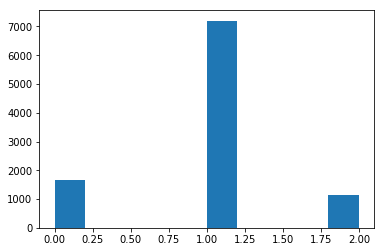

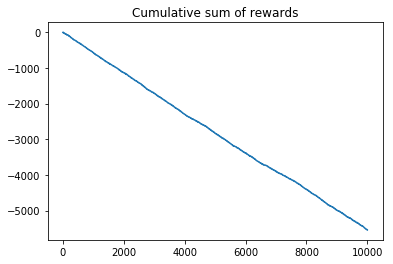

For the 1 Player:
 Number of wins =  1657 
 Number of losses =  7200 
 Number of draws =  1143
Player 1, level =  0
Player 2, level =  2


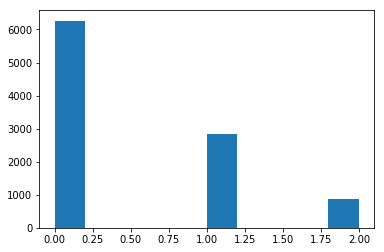

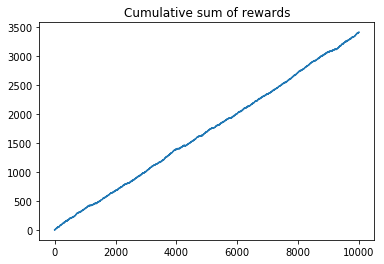

For the 1 Player:
 Number of wins =  6264 
 Number of losses =  2850 
 Number of draws =  886
Player 1, level =  1
Player 2, level =  0


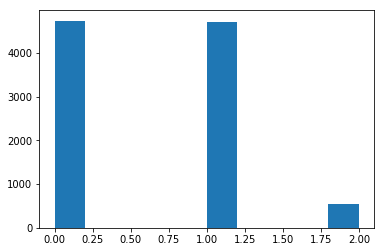

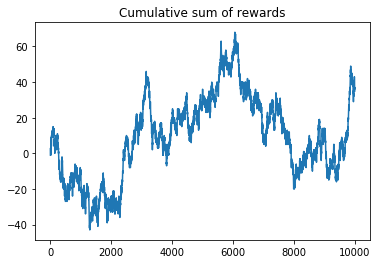

For the 1 Player:
 Number of wins =  4743 
 Number of losses =  4708 
 Number of draws =  549
Player 1, level =  1
Player 2, level =  1


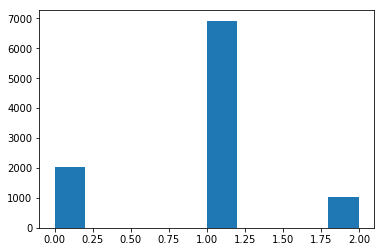

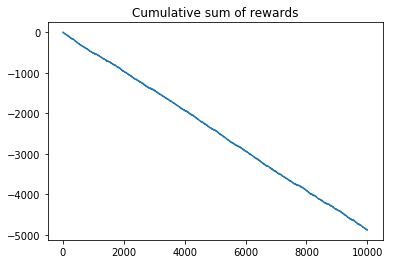

For the 1 Player:
 Number of wins =  2048 
 Number of losses =  6923 
 Number of draws =  1029
Player 1, level =  1
Player 2, level =  2


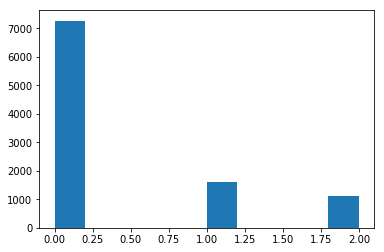

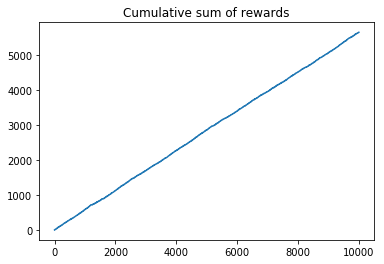

For the 1 Player:
 Number of wins =  7262 
 Number of losses =  1607 
 Number of draws =  1131
Player 1, level =  2
Player 2, level =  0


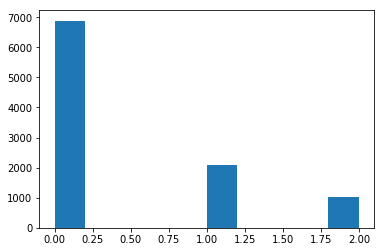

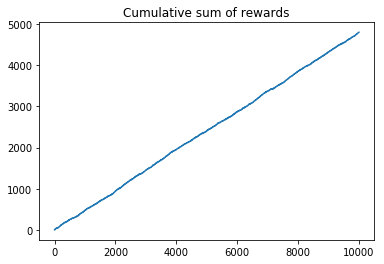

For the 1 Player:
 Number of wins =  6882 
 Number of losses =  2078 
 Number of draws =  1040
Player 1, level =  2
Player 2, level =  1


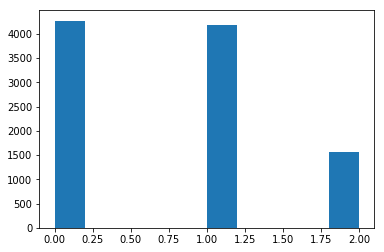

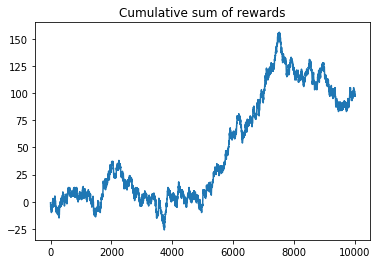

For the 1 Player:
 Number of wins =  4272 
 Number of losses =  4174 
 Number of draws =  1554
Player 1, level =  2
Player 2, level =  2


In [17]:
# Tournament
a = TicTacToe(start_rand = True)
for i in [0,1,2]:
    for j in [0,1,2]:
        a.run_play(i, move_type_2 = j)
        print "Player 1, level = ",i
        print "Player 2, level = ",j

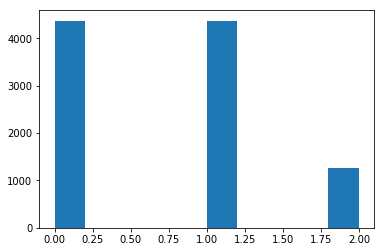

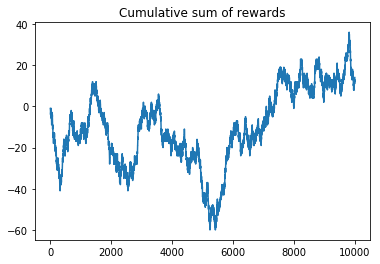

For the 1 Player:
 Number of wins =  4373 
 Number of losses =  4359 
 Number of draws =  1268


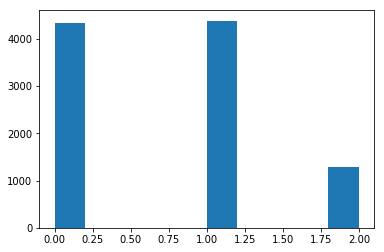

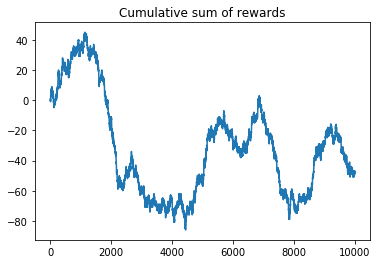

For the 1 Player:
 Number of wins =  4336 
 Number of losses =  4384 
 Number of draws =  1280


[4336, 4384, 1280]

In [88]:
# Filling in the Q-table using random moves
a = TicTacToe(start_rand = False)
a.run_play(q_learning_1 = True)
a.run_play(q_learning_1 = True)

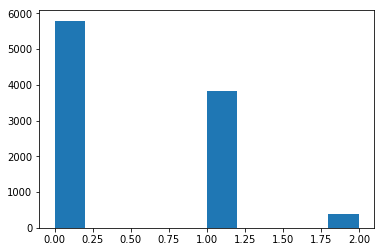

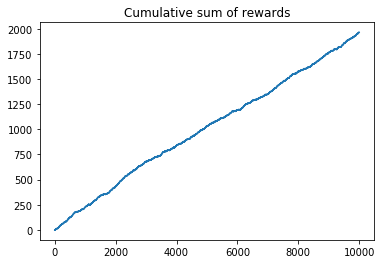

For the 1 Player:
 Number of wins =  5791 
 Number of losses =  3827 
 Number of draws =  382


[5791, 3827, 382]

In [89]:
# Using the Q-table for the Player 1
a.run_play(0)

Unfortunately, the q-learning algorithm works worse than "smart" and "smarter" players...

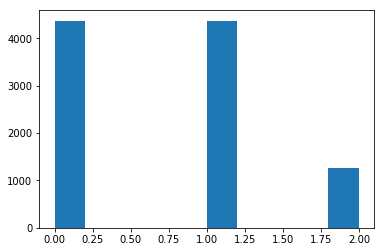

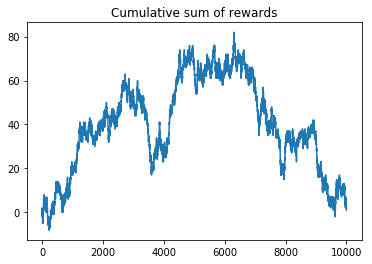

For the 1 Player:
 Number of wins =  4368 
 Number of losses =  4367 
 Number of draws =  1265


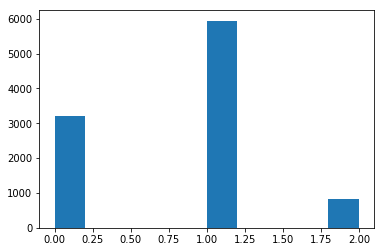

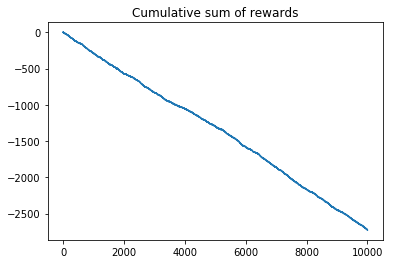

For the 1 Player:
 Number of wins =  3217 
 Number of losses =  5943 
 Number of draws =  840


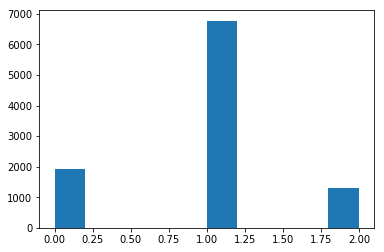

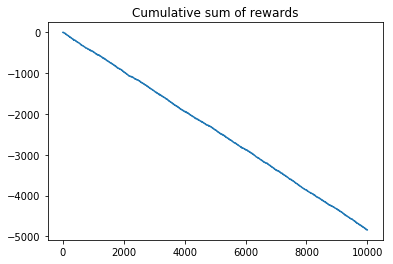

For the 1 Player:
 Number of wins =  1936 
 Number of losses =  6777 
 Number of draws =  1287


[1936, 6777, 1287]

In [83]:
# Training NN using random moves, smart and smart players as opponents
a = TicTacToe(start_rand = False)
a.tf_play(dq_learning_1 = True)
a.tf_play(1,2,dq_learning_1 = True)
a.tf_play(1,3,dq_learning_1 = True)

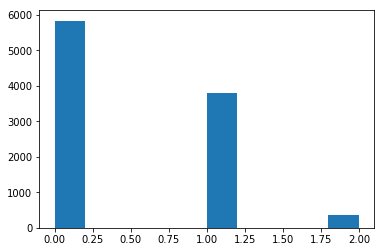

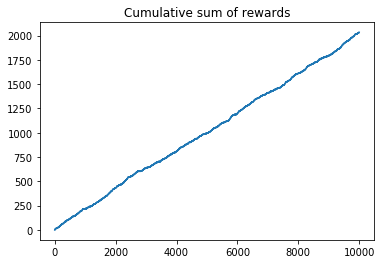

For the 1 Player:
 Number of wins =  5836 
 Number of losses =  3801 
 Number of draws =  363


[5836, 3801, 363]

In [84]:
# Despite trying to optimize the result, NN didn't work that well for me - it still plays weaker then a smart player
a.tf_play(0)